In [31]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [153]:
global trainData, testData, genderSubmissionData
trainDataDirectory = "/titanic/train.csv"
testDataDirectory = "/titanic/test.csv"
genderSubmissionDirectory = "/titanic/gender_submission.csv"

In [154]:
for dirname, _, filenames in os.walk(".../input"):
    for filename in filenames:
        csv = os.path.join(dirname, filename)
        if filename in trainDataDirectory:
            trainData = pd.read_csv(csv)
        elif filename in testDataDirectory:
            testData = pd.read_csv(csv)
        elif filename in genderSubmissionDirectory:
            genderSubmissionData = pd.read_csv(csv)
        else:
                pass

In [78]:
trainData

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Analyzing the train dataset

In [88]:
ss = trainData[["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean()
ss

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [89]:
ps = trainData[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean()
ps

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Ploting

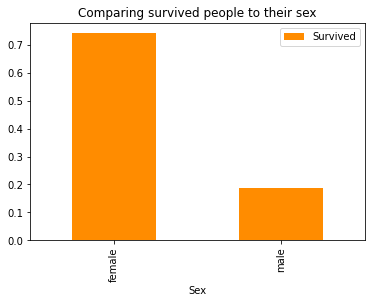

In [152]:
ss.plot(x="Sex", y="Survived", kind="bar", title="Comparing survived people to their sex", color="DarkOrange")

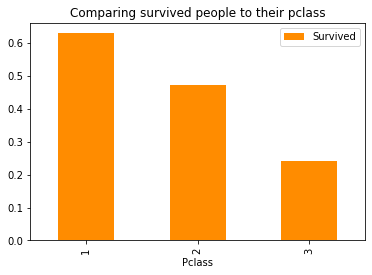

In [150]:
ps.plot(x ="Pclass", y="Survived", kind="bar", title="Comparing survived people to their pclass", color="DarkOrange")